<a href="https://colab.research.google.com/github/MadushanPathirana/msc-research/blob/main/atoms_adaptive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch_geometric


## Paddin wih LSTM resource and other resources


* https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec

* https://discuss.pytorch.org/t/trouble-with-packed-padded-sequence-and-lstm-for-variable-length-inputs/50028

* https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

* https://colab.research.google.com/drive/1jDiuseAdtZCYbAX2IRv2HU8zG5585bRi?usp=sharing

In [ ]:
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt;
np.random.seed(42);
from sklearn.metrics import roc_auc_score;
import urllib.request
from tqdm import tqdm
from datetime import datetime

import torch_geometric as pyg
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
#from torch_geometric.nn import  to_hetero ,LSTMAggregation
import  torch.nn as nn
import torch.nn.functional as F
import torch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData,Data
import torch
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.utils.rnn as rnn_utils
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.graph_objects as go

In [ ]:
def time_difference(start_time):
  """
  Calculates the time difference between the current time and a given starting time.

  Args:
    start_time: A datetime object representing the starting time.

  Returns:
    A timedelta object representing the time difference between the current time and the starting time.
  """

  current_time = datetime.now()
  time_diff = current_time - start_time
  return time_diff.seconds /60



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print(device.type)

cpu


# Configurations


In [ ]:
batch_size = 10 # number of users per batch
block_size = 5 # sequnce length
train_split = .80
skill_embd_dim = 128
num_epochs = 10
num_LSTM_layers = 1
hidden_size = 100
lr = 0.0005
wd = 1e-10

out_channels=1

### good combination of configurations
**Config 1**
-----------

* batch_size = 32
* block_size = 10
* train_split = .82
* skill_embd_dim = 120
* num_epochs = 10
* num_LSTM_layers = 1
* hidden_size = 100
* out_channels=1 , 2 GNN hidden layers , Graphsage model

**Config 2**
-----------

* batch_size = 24 # number of users per batch
* block_size = 3 # sequnce length
* train_split = .82
* skill_embd_dim = 256
* num_epochs = 10
* num_LSTM_layers = 1
* hidden_size = 300
* lr = 0.0005
* wd = 1e-10
* out_channels=1 , 3  GNN layers , GAT model

**Config 3**

* batch_size = 10 # number of users per batch
* block_size = 3 # sequnce length
* train_split = .82
* skill_embd_dim = 128
* num_epochs = 10
* num_LSTM_layers = 1
* hidden_size = 100
* lr = 0.0005
* wd = 1e-10
* out_channels=1 , 3  GNN layers , GAT model

# Read data

In [ ]:
#df = pd.read_pickle('https://github.com/MadushanPathirana/msc-research/raw/main/adaptive%20learning/creating%20graph/working_model/dfUsers.pickle')



#df = pd.read_csv("https://raw.githubusercontent.com/MadushanPathirana/msc-research/main/adaptive%20learning/creating%20graph/working_model/df_13.csv")
df = pd.read_pickle('https://github.com/MadushanPathirana/msc-research/raw/main/adaptive%20learning/creating%20graph/working_model/dfUsers.pickle')

df['interaction_end_time'] = pd.to_datetime(df.interaction_end_time)

users_to_drop = df.groupby('user_id')['interaction_end_time'].nunique()[df.groupby('user_id')['interaction_end_time'].nunique()<int(block_size/2)].index.tolist()
df= df[~df.user_id.isin( users_to_drop)]
df =df.sort_values(['goal_id','user_id','interaction_end_time'])
df['Question_number'] = df.groupby('user_id').cumcount() + 1


In [ ]:
df.shape

(73398, 21)

In [ ]:
# Download the file locally
url = 'https://github.com/MadushanPathirana/msc-research/raw/main/adaptive%20learning/creating%20graph/working_model/df2.pickle'
urllib.request.urlretrieve(url, 'df2.pickle')

# Load the local pickle file
df2 = pd.read_pickle('df2.pickle')

In [ ]:
df.goal_id.nunique()

162

In [ ]:
df.describe(include='all')

In [ ]:
df.describe().columns

Index(['time_spent_answering_s', 'time_spent_on_instruction_s',
       'goal_progress', 'duration_s', 'loGraphID', 'difficulty',
       'lo_difficulty', 'label', 'Question_number'],
      dtype='object')

# Preprocessing data


In [ ]:
def create_graph(df, df2, loGraphID):

  lo_edges = df2[df2['graph_id']==loGraphID][['source_index','dest_index']].values.transpose()



  lo_atom_edges=df[['loIndex','atomIndex']].drop_duplicates().values.transpose()

  edge_index =  torch.from_numpy(np.concatenate([lo_edges,lo_atom_edges],axis=1)).long().to(device)

  graph = Data(edge_index= edge_index)


  return graph

def preprocess_data(data):
    """
    Pre-process data and pad to the maximum length.
    """
    features = ['loIndex', 'atomIndex','correctBinary']
    seqs = data.groupby(['user_id']).apply(lambda x: x[features].values.tolist())
    # ensure sequence is not too long
    length = min(max(seqs.str.len()), block_size)
    seqs = seqs.apply(lambda s: s[:length] + (length - min(len(s), length)) * [[-1000] * len(features)])
    return seqs


def process_dataframe(df,df2,loGraphID):
  atom_index={atom_id:i for i,atom_id  in  enumerate(df.atom_id.unique())}

  df['atomIndex']=df.atom_id.map(atom_index)
  lo_map=pd.concat([df2[df2['graph_id']==loGraphID][['source_lo_title','source_index']].rename(columns={'source_lo_title':'learning_objective_name','source_index':'loIndex'}),
                      df2[df2['graph_id']==loGraphID][['dest_lo_title','dest_index']].rename(columns={'dest_lo_title':'learning_objective_name','dest_index':'loIndex'})]).drop_duplicates().reset_index(drop=True)
  #print(lo_map)
  df3=df.merge(lo_map,on='learning_objective_name',how='left')
  lo_count=lo_map['loIndex'].max()+1
  df3.loc[:  , 'atomIndex'] = df3.loc[:  , 'atomIndex']  + lo_count

  skill_grpah = create_graph(df3, df2, loGraphID)
  return df3 ,skill_grpah

def train_test_split(df):
    """
    Performs a deterministic train-test split based on the tabular data provided.
    Note that this function needs to be called twice to perform a train-val-test
    split as desired.

    Arguments:
      - data: tabular KT dataset (pd.DataFrame)

    Returns:
      - data_train: training dataset
      - data_val: validation/testing dataset
    """
    print(df.loGraphID.unique())
    loGraphID = df.loGraphID.unique()[0]
    data ,skill_graph = process_dataframe(df,df2,loGraphID)
    np.random.seed(42)
    #data = data.set_index(['user_id', 'loIndex'])
    data = data.set_index('user_id')
    idx = np.random.permutation(data.index.unique())
    train_idx, test_idx = idx[:int(train_split * len(idx))], idx[int(train_split * len(idx)):]
    data_train = data.loc[train_idx].reset_index()
    data_val = data.loc[test_idx].reset_index()
    return data, data_train, data_val, skill_graph

def construct_batches(raw_data, epoch = 0, val = False):
    """
    Construct batches based on tabular KT data with user_id, skill_id, and
    correctness. Pads to the minimum of the maximum sequence length and the
    block size of the transformer.
    """
    np.random.seed(epoch)
    user_ids = raw_data['user_id'].unique()

    # Loop until one epoch of training.
    for _ in range(len(user_ids) // batch_size):
        user_idx = raw_data['user_id'].sample(batch_size).unique() if not val else user_ids[_ * (batch_size // 2): (_ + 1) * (batch_size // 2)]
        filtered_data = raw_data[raw_data['user_id'].isin(user_idx)].sort_values(['user_id', 'interaction_end_time'])
        batch_preprocessed = preprocess_data(filtered_data)
        batch = np.array(batch_preprocessed.to_list())


        X = torch.tensor(batch[:, :, ..., :], requires_grad=True, dtype=torch.float32).to(device)
        y = torch.tensor(batch[:, :, ..., [-1]], requires_grad=True, dtype=torch.float32).to(device)
        #print(X.shape,y.shape)
        for i in range(X.shape[1] // block_size + 1):
            #print(X[:, i * block_size: (i + 1) * block_size].shape)
            if X[:, i * block_size: (i + 1) * block_size].shape[1] > 0:
                yield [X[:, i * block_size: (i + 1) * block_size], y[:, i * block_size: (i + 1) * block_size]]




In [ ]:
df.describe()

,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,duration_s,loGraphID,difficulty,lo_difficulty,label,Question_number
count,73398.000000,73398.000000,73396.000000,73398.000000,73398.0,73398.000000,73398.000000,73398.000000,73398.000000
mean,64.191330,8.260422,0.498306,72.451744,3.0,0.539026,0.539028,1.579961,217.450980
std,134.984711,34.231831,0.303674,143.882309,0.0,0.165594,0.091478,0.924616,208.464618
min,0.000000,0.000000,0.000000,0.000000,3.0,0.000000,0.366224,0.000000,1.000000
25%,10.765250,1.940000,0.212731,14.103000,3.0,0.413420,0.488746,1.000000,66.000000
50%,23.357000,2.953000,0.515141,28.579000,3.0,0.518519,0.514105,2.000000,159.000000
75%,57.683751,5.590000,0.765879,67.172253,3.0,0.656904,0.590885,2.000000,298.000000
max,1790.223022,1740.448975,1.000000,2614.633057,3.0,1.000000,0.880196,3.000000,1396.000000


In [ ]:
temp_user=['b7e8bc9f-2362-4aba-8167-aa42400eb156','1ea23ee9-deda-48f2-8ea9-98c895aa02bb','3eb9212c-523a-49fb-a670-3a51ae1ff87e','c7e39c9c-39dc-42bd-a4ee-c622edecf3c9']

In [ ]:
data, data_train , data_val, skill_graph = train_test_split(df[df.user_id.isin(temp_user)])

[3.]


<ipython-input-37-c5aa0caf155c>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atomIndex']=df.atom_id.map(atom_index)


In [ ]:
def create_blocks(df):

    df['block_user_id'] = df['user_id'] + '_' + ((df.groupby(['user_id']).cumcount() // block_size) + 1).astype(str)
    return df



In [ ]:

result_df = create_blocks(data_val)#[['goal_id','user_id','interaction_end_time','atom_id','atomIndex','loIndex','Question_number','block_user_id']]
result_df

,user_id,graph_id,goal_id,interaction_end_time,learning_objective_name,atom_id,correct,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,...,loGraphID,difficulty,lo_difficulty,atom_type,correctBinary,label,Question_number,atomIndex,loIndex,block_user_id
0,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:38:25.944,Solve an application problem by applying Polya...,c2571c28-c337-4831-aecb-3e1d78acaeca,True,93.278999,66.130997,0.167121,...,3.0,0.951754,0.593100,question,1,3.0,1,57,27,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_1
1,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:41:56.281,Solve an application problem by applying Polya...,7cae6bd4-3130-4862-af34-60f8dde81549,True,166.416000,43.921001,0.449828,...,3.0,0.801762,0.593100,question,1,3.0,2,58,27,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_1
2,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:46:32.247,Solve an application problem by applying Polya...,a4874bfd-b6ed-47a2-ba73-2809753efe6a,False,239.904007,35.842999,0.422112,...,3.0,0.329670,0.593100,question,0,3.0,3,59,27,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_1
3,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:49:39.611,Solve an application problem by applying Polya...,48ce9017-cd13-48d3-bf31-d48fa5d9a811,False,134.813004,6.597000,0.156556,...,3.0,0.763889,0.593100,question,0,3.0,4,60,27,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_1
4,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:51:28.290,Solve an application problem by applying Polya...,48ce9017-cd13-48d3-bf31-d48fa5d9a811,False,101.212997,4.400000,0.049851,...,3.0,0.763889,0.593100,question,0,3.0,5,60,27,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_1
5,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:54:06.168,Solve an application problem by applying Polya...,68f9f47f-24fd-44fb-97ae-22d12f9c1acd,False,146.108994,11.571000,0.019693,...,3.0,0.541176,0.593100,question,0,3.0,6,61,27,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_2
6,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:56:12.602,Solve an application problem by applying Polya...,3cc23c34-60df-468d-898e-fe2df9f24d2a,False,107.154999,19.065001,0.008083,...,3.0,0.638889,0.593100,question,0,3.0,7,62,27,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_2
7,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 01:58:07.771,Identify the piece of information needed to so...,4c88bbdd-8b91-4191-b393-f6f2070d38ff,True,112.459999,2.462000,0.012172,...,3.0,0.640000,0.576848,question,1,3.0,8,63,22,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_2
8,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 02:01:34.181,Identify the piece of information needed to so...,6e7cb56f-343b-468b-8db8-7c112a16e38d,False,194.873993,11.349000,0.008988,...,3.0,0.415493,0.576848,question,0,3.0,9,64,22,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_2
9,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,3e9e4078-e256-4d8b-9414-207f32eb91f3,2022-08-26 02:03:11.016,Identify the piece of information needed to so...,d78f852a-a266-4e1c-a3b9-36a74ce2f6b3,False,96.635002,0.000000,0.005771,...,3.0,0.707865,0.576848,question,0,3.0,10,65,22,c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_2


In [ ]:
result_df.describe()

,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,duration_s,loGraphID,difficulty,lo_difficulty,label,Question_number,atomIndex,loIndex
count,22.000000,22.000000,22.000000,22.000000,22.0,22.000000,22.000000,22.0,22.000000,22.000000,22.000000
mean,100.711678,12.381181,0.373235,113.092865,3.0,0.760789,0.722139,3.0,11.500000,67.272727,27.227273
std,73.347267,16.435415,0.312935,81.180077,0.0,0.189723,0.127668,0.0,6.493587,7.045308,2.287269
min,5.414000,0.000000,0.005771,7.823000,3.0,0.329670,0.576848,3.0,1.000000,57.000000,22.000000
25%,55.271499,2.422250,0.068638,57.719248,3.0,0.640338,0.593100,3.0,6.250000,61.250000,27.000000
50%,95.997002,5.498500,0.398556,108.558498,3.0,0.814027,0.810504,3.0,11.500000,66.000000,28.000000
75%,129.224752,15.041500,0.580438,153.612495,3.0,0.914530,0.810504,3.0,16.750000,73.750000,29.000000
max,287.675995,66.130997,1.000000,303.746002,3.0,0.977011,0.880196,3.0,22.000000,79.000000,29.000000


In [ ]:
def preprocess_data_2(data):
    """
    Pre-process data and pad to the maximum length.
    """
    create_blocks(data)
    features = ['loIndex', 'atomIndex','correctBinary']
    seqs = data.groupby(['block_user_id']).apply(lambda x: x[features].values.tolist())
    # ensure sequence is not too long
    length = min(max(seqs.str.len()), block_size)
    seqs = seqs.apply(lambda s: s[:length] + (length - min(len(s), length)) * [[-1000] * len(features)])
    return seqs


In [ ]:
preprocess_data_2(result_df)

block_user_id
c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_1    [[27, 57, 1], [27, 58, 1], [27, 59, 0], [27, 6...
c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_2    [[27, 61, 0], [27, 62, 0], [22, 63, 1], [22, 6...
c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_3    [[29, 73, 1], [29, 74, 1], [28, 68, 1], [28, 7...
c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_4    [[29, 66, 1], [29, 76, 0], [29, 66, 1], [29, 7...
c7e39c9c-39dc-42bd-a4ee-c622edecf3c9_5    [[28, 69, 1], [28, 79, 1], [-1000, -1000, -100...
dtype: object

# GNN Models


## GraphSAGE

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a GraphSAGE graph neural network with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GraphSAGE'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.conv4 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu4 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, edge_index):
        """
        Runs a forward pass through GraphSAGE with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h0 = self.pre_embs(x) # initial skill embedding
        h1 = self.dropout(self.prelu1(self.conv1(h0, edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.dropout(self.prelu2(self.conv3(h1, edge_index)))
        h4 = self.prelu3(self.conv4(h3, edge_index))
        return self.out(h4)

## GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a simple Graph Convolutional Network (GCN) with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GCN'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        """
        Runs a forward pass through the GCN with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h0 = self.pre_embs(x) # initial skill embedding
        h1 = self.dropout(self.prelu1(self.conv1(h0, edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.prelu3(self.conv3(h2, edge_index))
        return self.out(h3)

## GAT

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a Graph Attention Network (GAT) with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GAT'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = GATConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = GATConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        """
        Runs a forward pass through GAT with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h1 = self.dropout(self.prelu1(self.conv1(self.pre_embs(x), edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.prelu3(self.conv3(h2, edge_index))
        return self.out(h3)

# LSTM Model

In [ ]:



class LSTM(nn.Module):

    def __init__(self ):
        super().__init__()
        self.num_layers = num_LSTM_layers # number of recurrent layers in the lstm
        self.input_size = skill_embd_dim*2 # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.sigmoid=nn.Sigmoid()

        self.lstm = nn.LSTM(
            input_size=self.input_size ,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,dropout=.2
        )
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self,x):

        h0 = torch.zeros(self.lstm.num_layers, x.data.size(0), self.hidden_size).requires_grad_().to(device)
        # Initialize long-term memory
        c0 = torch.zeros(self.lstm.num_layers, x.data.size(0), self.hidden_size).requires_grad_().to(device)
        # Pass all inputs to lstm layer
        out, (hn0, cn0) = self.lstm(x, (h0, c0))

        #unpack padded sequnce
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out,batch_first=True)

        #print(out.shape)
        out = self.sigmoid( self.fc(unpacked))
        #out = self.sigmoid( self.fc(hn0))
        return out

# Classifier

In [ ]:
class Classifer(nn.Module):
  def __init__(self,num_skills):
    super().__init__()

    self.num_skills=num_skills
    print(self.num_skills)
    self.LSTM = LSTM()
    self.gnn = GAT(self.num_skills)

  def forward(self,skill_grpah ,X ):
    all_skill_embd  = self.gnn(torch.arange(self.num_skills).to(device), skill_grpah.edge_index)


    skill_embd_index = torch.where(X[..., :2] == -1000, 0 , X[..., :2]).long()
    skill_embd = all_skill_embd[skill_embd_index]
    skill_embd_packed_reshaped = skill_embd.view(skill_embd.shape[0],block_size,skill_embd_dim*2)

    mask = (X[:,:,0] != -1000).float()

    # Calculating sequence length for each batch
    sequence_lengths = mask.sum(dim=1).long()

    skill_embd_packed = rnn_utils.pack_padded_sequence(skill_embd_packed_reshaped, sequence_lengths, batch_first=True, enforce_sorted=False)

    out = self.LSTM( skill_embd_packed)
    return out , all_skill_embd



# Init model

In [ ]:


def init_model(loGraphID):
  data,data_train, data_test ,skill_graph = train_test_split(df)
  skill_graph.to(device)

  num_skills = skill_graph['edge_index'].max()+1
  model = Classifer(num_skills)
  model.to(device)

  optimizer=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd )

  return model, data_train , data_test , skill_graph , optimizer



# Train and Test

In [ ]:
def model_perfomance(model,outputs, ytrue ):

  model.eval()

  accuracy = np.mean(np.round(outputs)==ytrue)
  print(len(ytrue))


  roc_auc = roc_auc_score(ytrue, outputs)
  return accuracy ,roc_auc

In [ ]:
def test(model,data_test,skill_grpah,epoch,optimizer):
  model.eval()
  with torch.no_grad():
    losses=[]
    batches_train = construct_batches(data_test,epoch = epoch,val = True)
    pbar = iter(batches_train)
    outputs= []
    ytrue = []
    for X, y in pbar:


      optimizer.zero_grad()
      output , all_skill_embd = model(skill_grpah,X)
      mask = y[..., -1] != -1000


      loss=F.binary_cross_entropy(output[mask], y[..., -1:][mask])

      outputs.extend(output[mask].ravel().detach().tolist())
      ytrue.extend(y[..., -1:][mask].ravel().detach().tolist())
      losses.append(loss.item())
    accuracy ,roc_auc = model_perfomance(model , outputs, ytrue)
    print(f'Test ->     loss : {np.mean(losses) :.5f} , accuracy : {accuracy : .2%} , roc_auc : {roc_auc : .2%} \n')

    return np.mean(losses) ,accuracy ,roc_auc

In [ ]:
def results(train_losses,test_losses,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc):
  fig,axs=plt.subplots(1,3,figsize=(18,7))
  x_ticks = np.arange(0,len(train_losses),3)
  axs[0].plot(train_losses, label = 'train')
  axs[0].plot(test_losses, label = 'test')
  axs[0].set_ylabel('loss')
  axs[0].legend()
  axs[0].set_xticks(x_ticks,x_ticks)
  axs[0].set_xticklabels( x_ticks,rotation=45)
  axs[0].grid()

  axs[1].plot(train_accuracy, label = 'train')
  axs[1].plot(test_accuracy, label = 'test')
  axs[1].set_ylabel('accuracy')
  axs[1].legend()
  axs[1].set_xticks(x_ticks,x_ticks)
  axs[1].set_xticklabels( x_ticks,rotation=45)
  axs[1].grid()

  axs[2].plot(train_roc_auc, label = 'train')
  axs[2].plot(test_roc_auc, label = 'test')
  axs[2].set_ylabel('roc_auc')
  axs[2].legend()
  axs[2].set_xticks(x_ticks,x_ticks)
  axs[2].set_xticklabels( x_ticks,rotation=45)
  axs[2].grid()

  plt.tight_layout()


def exp_results(train_losses,test_losses,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,epoches,no_of_exp):
  fig,axs=plt.subplots(1,3,figsize=(18,7))

  x_ticks = np.arange(1,epoches+1)
  x = np.tile(np.arange(1,epoches+1), no_of_exp)

  sns.lineplot(x=x,y=train_losses,label = 'train',ax=axs[0])
  sns.lineplot(x=x,y=test_losses,label = 'test',ax=axs[0])
  axs[0].set_title('Learning curve')
  axs[0].set_ylabel('loss')
  axs[0].set_xticks(x_ticks,x_ticks)
  axs[0].set_xticklabels( x_ticks,rotation=45)
  axs[0].grid()

  sns.lineplot(x=x,y=train_accuracy,label = 'train',ax=axs[1])
  sns.lineplot(x=x,y=test_accuracy,label = 'test',ax=axs[1])
  axs[1].set_title('Accuracy')
  axs[1].set_ylabel('accuracy')
  axs[1].set_xticks(x_ticks,x_ticks)
  axs[1].set_xticklabels( x_ticks,rotation=45)
  axs[1].grid()

  sns.lineplot(x=x,y=train_roc_auc,label = 'train',ax=axs[2])
  sns.lineplot(x=x,y=test_roc_auc,label = 'test',ax=axs[2])
  axs[2].set_title('ROC AUC')
  axs[2].set_ylabel('roc_auc')
  axs[2].set_xticks(x_ticks,x_ticks)
  axs[2].set_xticklabels( x_ticks,rotation=45)
  axs[2].grid()

  fig.suptitle('Model Performance with Question Embeddings',fontsize=20)
  plt.tight_layout()
  plt.show()




In [ ]:

def train(epoches):
  graph_id = df.loGraphID.unique()[0]
  model, data_train , data_test , skill_grpah , optimizer =  init_model(graph_id)
  print(skill_grpah)
  train_losses =[]
  test_losses = []

  train_accuracy = []
  test_accuracy = []

  train_roc_auc = []
  test_roc_auc = []

  for epoch in range(epoches):
    model.train()
    losses=[]
    batches_train = construct_batches(data_train,epoch = epoch)
    pbar = iter(batches_train)
    outputs= []
    ytrue = []

    for X, y in pbar:


      optimizer.zero_grad()
      output,all_skill_embd = model(skill_grpah,X)
      mask = y[..., -1] != -1000


      loss = F.binary_cross_entropy(output[mask], y[..., -1:][mask])
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      outputs.extend(output[mask].ravel().detach().tolist())
      ytrue.extend(y[..., -1:][mask].ravel().detach().tolist())

    train_acc ,train_roc_acu_score = model_perfomance(model , outputs, ytrue)
    train_loss = np.mean(losses)
    print(train_loss)
    print(f'epoch : {epoch} , loss : {np.mean(losses) :.5f} , accuracy : {train_acc : .2%} , roc_acu : {train_roc_acu_score :.2%}')
    test_loss, test_acc,test_roc_auc_score =test(model,data_test,skill_grpah,epoch,optimizer)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    train_roc_auc.append(train_roc_acu_score)
    test_roc_auc.append(test_roc_auc_score)

  results(train_losses, test_losses,
          train_accuracy, test_accuracy,
          train_roc_auc,test_roc_auc)

  return all_skill_embd

# Results

[3.]
tensor(713)
Data(edge_index=[2, 723])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1214
0.5434315264225006
epoch : 0 , loss : 0.54343 , accuracy :  75.62% , roc_acu : 66.80%
150
Test ->     loss : 0.53212 , accuracy :  78.00% , roc_auc :  55.93% 

1215
0.53285364985466
epoch : 1 , loss : 0.53285 , accuracy :  75.97% , roc_acu : 62.01%
150
Test ->     loss : 0.52344 , accuracy :  78.00% , roc_auc :  56.36% 

1205
0.4730270099639893
epoch : 2 , loss : 0.47303 , accuracy :  79.34% , roc_acu : 66.33%
150
Test ->     loss : 0.52744 , accuracy :  78.00% , roc_auc :  58.80% 

1225
0.48835030317306516
epoch : 3 , loss : 0.48835 , accuracy :  77.80% , roc_acu : 71.56%
150
Test ->     loss : 0.50111 , accuracy :  77.33% , roc_auc :  63.37% 

1195
0.47317150473594666
epoch : 4 , loss : 0.47317 , accuracy :  78.74% , roc_acu : 72.94%
150
Test ->     loss : 0.50637 , accuracy :  80.67% , roc_auc :  65.74% 

1220
0.4577832317352295
epoch : 5 , loss : 0.45778 , accuracy :  79.43% , roc_acu : 74.28%
150
Test ->     loss : 0.49982 , accuracy :  80.67% , roc_auc :  67.03% 

1205
0.473

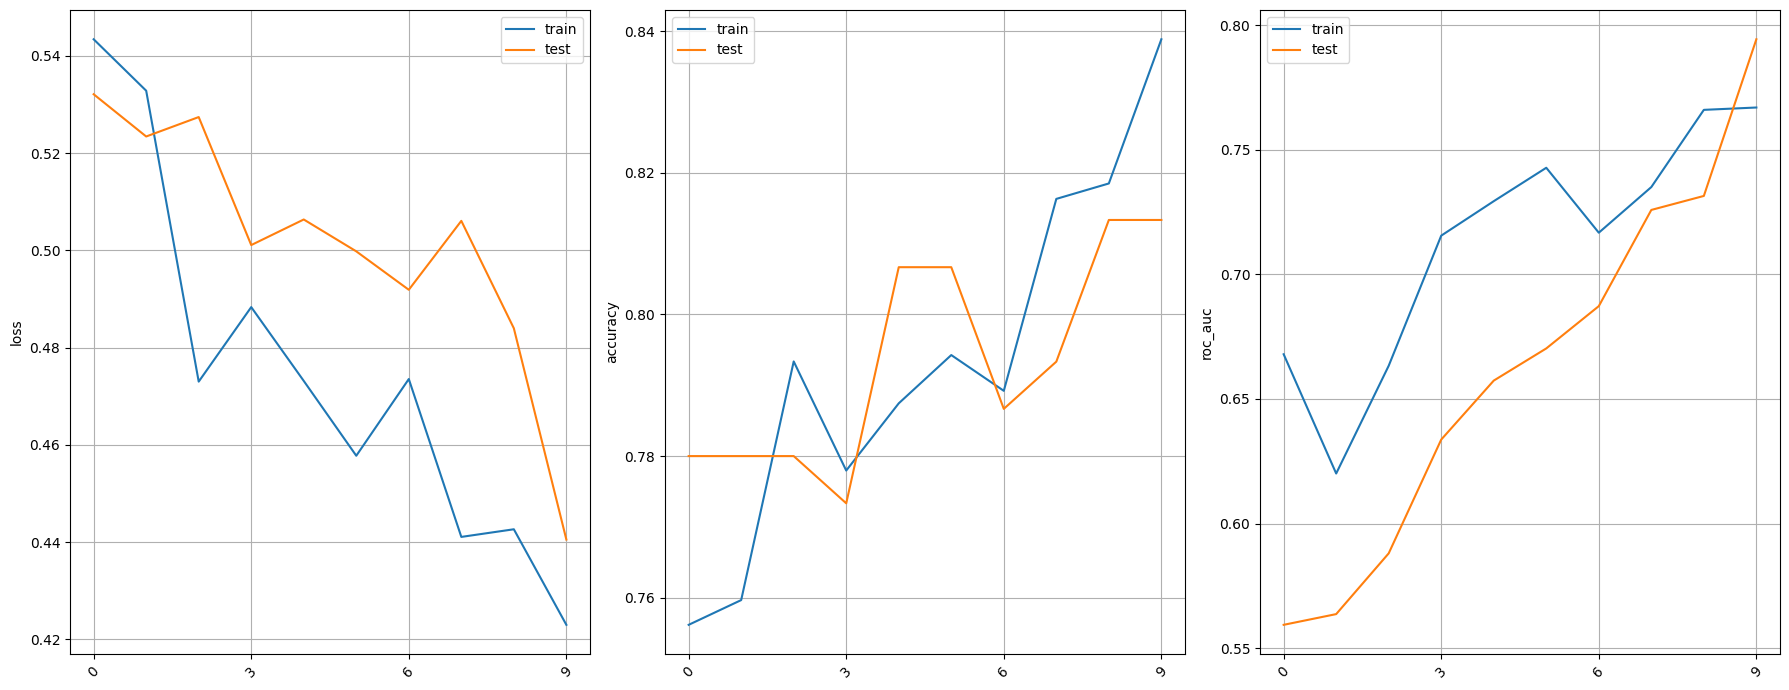

In [ ]:
all_skill_embd = train(10)

## Expriment

In [ ]:
def experiment(no_of_exp,epoches):
  graph_id = df.loGraphID.unique()[0]

  exp_train_losses =[]
  exp_test_losses = []
  exp_train_accuracy = []
  exp_test_accuracy = []
  exp_train_roc_auc = []
  exp_test_roc_auc = []

  for exp_no in range(no_of_exp):
    model, data_train , data_test , skill_grpah , optimizer =  init_model(graph_id)

    train_losses =[]
    test_losses = []

    train_accuracy = []
    test_accuracy = []

    train_roc_auc = []
    test_roc_auc = []

    for epoch in range(epoches):
      model.train()
      losses=[]
      batches_train = construct_batches(data_train,epoch = epoch)
      pbar = iter(batches_train)
      outputs= []
      ytrue = []

      for X, y in pbar:


        optimizer.zero_grad()
        output,all_skill_embd = model(skill_grpah,X)
        mask = y[..., -1] != -1000


        loss = F.binary_cross_entropy(output[mask], y[..., -1:][mask])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        outputs.extend(output[mask].ravel().detach().tolist())
        ytrue.extend(y[..., -1:][mask].ravel().detach().tolist())

      train_acc ,train_roc_acu_score = model_perfomance(model , outputs, ytrue)
      train_loss = np.mean(losses)
      print(train_loss)
      print(f'epoch : {epoch} , loss : {np.mean(losses) :.5f} , accuracy : {train_acc : .2%} , roc_acu : {train_roc_acu_score :.2%}')
      test_loss, test_acc,test_roc_auc_score =test(model,data_test,skill_grpah,epoch,optimizer)

      train_losses.append(train_loss)
      test_losses.append(test_loss)

      train_accuracy.append(train_acc)
      test_accuracy.append(test_acc)

      train_roc_auc.append(train_roc_acu_score)
      test_roc_auc.append(test_roc_auc_score)

    exp_train_losses.extend(train_losses)
    exp_test_losses.extend(test_losses)
    exp_train_accuracy.extend(train_accuracy)
    exp_test_accuracy.extend(test_accuracy)
    exp_train_roc_auc.extend(train_roc_auc)
    exp_test_roc_auc.extend(test_roc_auc)

  exp_results(exp_train_losses, exp_test_losses,
                exp_train_accuracy, exp_test_accuracy,
                exp_train_roc_auc,exp_test_roc_auc,epoches,no_of_exp)
  performace_dict = {  "losses_train"   : exp_train_losses  ,
                       'losses_test'    :exp_test_losses      ,
                       "accuracy_train" :  np.array(exp_train_accuracy)*100   ,
                       'accuracy_test'   : np.array(exp_test_accuracy )*100  ,
                       'roc_auc_train'   : np.array(exp_train_roc_auc )*100   ,
                       'roc_auc_test'     :np.array(exp_test_roc_auc  )*100}
  return performace_dict


[3.]
tensor(713)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1214
0.5570277786254882
epoch : 0 , loss : 0.55703 , accuracy :  73.06% , roc_acu : 64.94%
150
Test ->     loss : 0.53835 , accuracy :  78.00% , roc_auc :  56.12% 

1215
0.5311203980445862
epoch : 1 , loss : 0.53112 , accuracy :  76.13% , roc_acu : 63.16%
150
Test ->     loss : 0.52667 , accuracy :  78.00% , roc_auc :  56.55% 

1205
0.47537691295146944
epoch : 2 , loss : 0.47538 , accuracy :  79.67% , roc_acu : 64.68%
150
Test ->     loss : 0.53329 , accuracy :  78.00% , roc_auc :  59.59% 

1225
0.4976504373550415
epoch : 3 , loss : 0.49765 , accuracy :  76.98% , roc_acu : 68.14%
150
Test ->     loss : 0.52639 , accuracy :  75.33% , roc_auc :  61.38% 

1195
0.49468642950057984
epoch : 4 , loss : 0.49469 , accuracy :  78.66% , roc_acu : 69.29%
150
Test ->     loss : 0.53177 , accuracy :  77.33% , roc_auc :  71.31% 

1220
0.45267608046531677
epoch : 5 , loss : 0.45268 , accuracy :  78.20% , roc_acu : 78.78%
150
Test ->     loss : 0.43326 , accuracy :  78.00% , roc_auc :  80.33% 

1205
0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1214
0.552553197145462
epoch : 0 , loss : 0.55255 , accuracy :  73.31% , roc_acu : 65.81%
150
Test ->     loss : 0.53067 , accuracy :  78.00% , roc_auc :  56.06% 

1215
0.5310070085525512
epoch : 1 , loss : 0.53101 , accuracy :  76.30% , roc_acu : 62.26%
150
Test ->     loss : 0.52335 , accuracy :  78.00% , roc_auc :  55.62% 

1205
0.4778070688247681
epoch : 2 , loss : 0.47781 , accuracy :  78.51% , roc_acu : 63.44%
150
Test ->     loss : 0.52620 , accuracy :  78.00% , roc_auc :  55.02% 

1225
0.4938571560382843
epoch : 3 , loss : 0.49386 , accuracy :  78.61% , roc_acu : 67.31%
150
Test ->     loss : 0.51972 , accuracy :  78.67% , roc_auc :  55.69% 

1195
0.4870888352394104
epoch : 4 , loss : 0.48709 , accuracy :  80.00% , roc_acu : 69.93%
150
Test ->     loss : 0.52905 , accuracy :  78.00% , roc_auc :  61.48% 

1220
0.4622087574005127
epoch : 5 , loss : 0.46221 , accuracy :  80.33% , roc_acu : 74.83%
150
Test ->     loss : 0.45614 , accuracy :  78.00% , roc_auc :  76.33% 

1205
0.4489

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1214
0.5484676897525788
epoch : 0 , loss : 0.54847 , accuracy :  75.12% , roc_acu : 67.01%
150
Test ->     loss : 0.53590 , accuracy :  78.00% , roc_auc :  55.69% 

1215
0.5331101405620575
epoch : 1 , loss : 0.53311 , accuracy :  76.21% , roc_acu : 61.88%
150
Test ->     loss : 0.52371 , accuracy :  78.00% , roc_auc :  56.96% 

1205
0.47364152133464815
epoch : 2 , loss : 0.47364 , accuracy :  79.50% , roc_acu : 65.03%
150
Test ->     loss : 0.52889 , accuracy :  78.00% , roc_auc :  57.70% 

1225
0.49564920663833617
epoch : 3 , loss : 0.49565 , accuracy :  78.69% , roc_acu : 67.21%
150
Test ->     loss : 0.51886 , accuracy :  79.33% , roc_auc :  60.76% 

1195
0.48450685024261475
epoch : 4 , loss : 0.48451 , accuracy :  80.42% , roc_acu : 71.27%
150
Test ->     loss : 0.52796 , accuracy :  78.00% , roc_auc :  65.02% 

1220
0.46471948981285094
epoch : 5 , loss : 0.46472 , accuracy :  80.74% , roc_acu : 73.55%
150
Test ->     loss : 0.50626 , accuracy :  76.67% , roc_auc :  70.35% 

1205
0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1214
0.541400111913681
epoch : 0 , loss : 0.54140 , accuracy :  76.44% , roc_acu : 66.96%
150
Test ->     loss : 0.53291 , accuracy :  78.00% , roc_auc :  54.83% 

1215
0.5321741724014282
epoch : 1 , loss : 0.53217 , accuracy :  75.72% , roc_acu : 62.45%
150
Test ->     loss : 0.52732 , accuracy :  78.00% , roc_auc :  59.14% 

1205
0.47448089957237244
epoch : 2 , loss : 0.47448 , accuracy :  79.50% , roc_acu : 65.49%
150
Test ->     loss : 0.53109 , accuracy :  78.00% , roc_auc :  61.36% 

1225
0.49707094073295593
epoch : 3 , loss : 0.49707 , accuracy :  77.55% , roc_acu : 69.22%
150
Test ->     loss : 0.52063 , accuracy :  76.67% , roc_auc :  68.23% 

1195
0.4915326142311096
epoch : 4 , loss : 0.49153 , accuracy :  77.74% , roc_acu : 71.43%
150
Test ->     loss : 0.51857 , accuracy :  76.67% , roc_auc :  72.94% 

1220
0.4577161371707916
epoch : 5 , loss : 0.45772 , accuracy :  79.34% , roc_acu : 77.12%
150
Test ->     loss : 0.45250 , accuracy :  76.67% , roc_auc :  81.69% 

1205
0.45

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


1214
0.5474605178833007
epoch : 0 , loss : 0.54746 , accuracy :  75.29% , roc_acu : 65.80%
150
Test ->     loss : 0.53639 , accuracy :  78.00% , roc_auc :  59.18% 

1215
0.5279378652572632
epoch : 1 , loss : 0.52794 , accuracy :  76.30% , roc_acu : 64.59%
150
Test ->     loss : 0.51699 , accuracy :  78.00% , roc_auc :  66.34% 

1205
0.46073039770126345
epoch : 2 , loss : 0.46073 , accuracy :  79.00% , roc_acu : 71.79%
150
Test ->     loss : 0.48880 , accuracy :  78.67% , roc_auc :  76.36% 

1225
0.452755012512207
epoch : 3 , loss : 0.45276 , accuracy :  78.12% , roc_acu : 79.80%
150
Test ->     loss : 0.41933 , accuracy :  78.00% , roc_auc :  83.32% 

1195
0.42893834710121154
epoch : 4 , loss : 0.42894 , accuracy :  78.08% , roc_acu : 82.28%
150
Test ->     loss : 0.45118 , accuracy :  77.33% , roc_auc :  80.61% 

1220
0.4036530101299286
epoch : 5 , loss : 0.40365 , accuracy :  80.98% , roc_acu : 84.04%
150
Test ->     loss : 0.42045 , accuracy :  79.33% , roc_auc :  83.66% 

1205
0.43

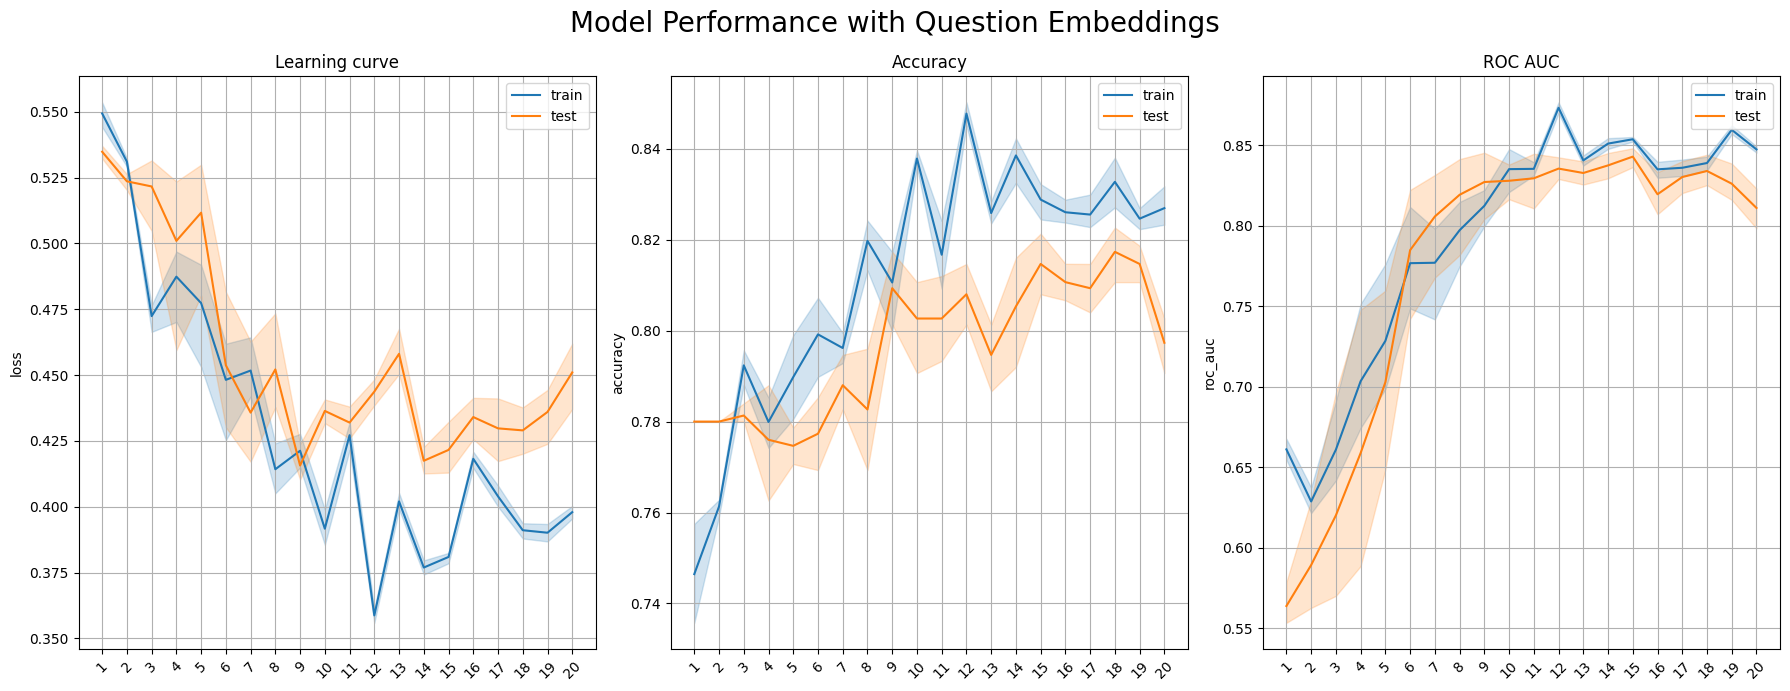

In [ ]:
no_of_exp= 5
epoches = 20
perfoamce_dict=experiment(no_of_exp,epoches)

In [ ]:
perfomace_df=pd.DataFrame(perfoamce_dict)
perfomace_df['epoches'] = np.repeat(np.arange(1,epoches+1),no_of_exp)

In [ ]:
perfomace_df.pivot_table(index='epoches'  , aggfunc=['mean','std']).swaplevel(axis=1).sort_index(axis=1).style.format('{:.3f}')


# Analysis

In [ ]:
data_set,train_data,test_data,skill_graph=train_test_split(df)

[3.]


In [ ]:
data_set.head()

,graph_id,goal_id,interaction_end_time,learning_objective_name,atom_id,correct,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,target_status_and_progress,...,is_target,loGraphID,difficulty,lo_difficulty,atom_type,correctBinary,label,Question_number,atomIndex,loIndex
user_id,,,,,,,,,,,,,,,,,,,,,
19bb3e1b-3843-4e10-bcbd-bc41e9502912,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,009e34c6-2086-4b8c-9a53-6c7603e874d4,2022-09-14 16:29:52.472,"Identify self-contradictions, tautologies, and...",4d6cda33-fd5c-481b-bee9-60ebfc596dd0,False,773.307983,102.941002,0.014028,{'500c7cd4-7116-4ce0-8a04-327763121a70': {'pro...,...,True,3.0,0.574163,0.50471,question,0,1.0,1,31,20
19bb3e1b-3843-4e10-bcbd-bc41e9502912,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,009e34c6-2086-4b8c-9a53-6c7603e874d4,2022-09-14 16:31:28.753,"Identify self-contradictions, tautologies, and...",c255cb27-c51f-4ac1-8e92-d87440b07921,True,93.579002,2.427000,0.276951,{'500c7cd4-7116-4ce0-8a04-327763121a70': {'pro...,...,True,3.0,0.477477,0.50471,question,1,1.0,2,32,20
19bb3e1b-3843-4e10-bcbd-bc41e9502912,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,009e34c6-2086-4b8c-9a53-6c7603e874d4,2022-09-14 16:35:30.253,"Identify self-contradictions, tautologies, and...",bc62d130-015e-4053-8cc2-b823cc628352,True,236.837997,4.403000,0.682561,{'500c7cd4-7116-4ce0-8a04-327763121a70': {'pro...,...,True,3.0,0.466667,0.50471,question,1,1.0,3,33,20
19bb3e1b-3843-4e10-bcbd-bc41e9502912,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,009e34c6-2086-4b8c-9a53-6c7603e874d4,2022-09-14 16:37:57.296,"Identify self-contradictions, tautologies, and...",860c1c8d-c61c-46cf-8e25-10d3d27ce856,True,97.551003,48.592999,1.000000,{'500c7cd4-7116-4ce0-8a04-327763121a70': {'pro...,...,True,3.0,0.260870,0.50471,question,1,1.0,4,34,20
2038ac47-6874-48b5-ad6f-cea7fd7cf0ee,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,009e34c6-2086-4b8c-9a53-6c7603e874d4,2022-09-08 10:04:48.239,"Identify self-contradictions, tautologies, and...",efd3b1af-67cb-4b01-a3a9-fcb767e25a9c,False,939.687988,39.858002,0.021283,{'500c7cd4-7116-4ce0-8a04-327763121a70': {'pro...,...,True,3.0,0.438095,0.50471,question,0,1.0,1,35,20


In [ ]:
lo_atom_map=data_set.reset_index()[['atomIndex','loIndex']].drop_duplicates()

In [ ]:
lo_atom_map

,atomIndex,loIndex
0,31,20
1,32,20
2,33,20
3,34,20
4,35,20
...,...,...
61688,708,11
61690,709,11
61694,710,11
61695,711,11


<Axes: >

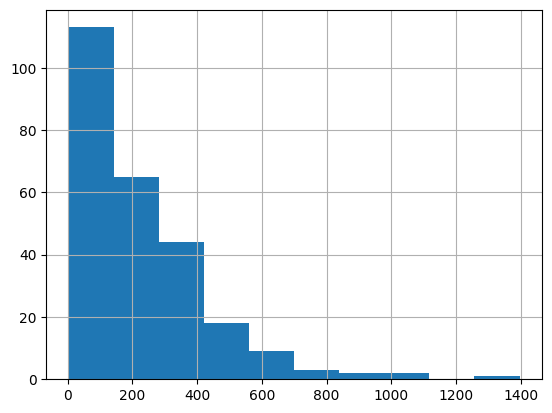

In [ ]:
train_data.groupby('user_id')['correct'].count().hist()

<Axes: >

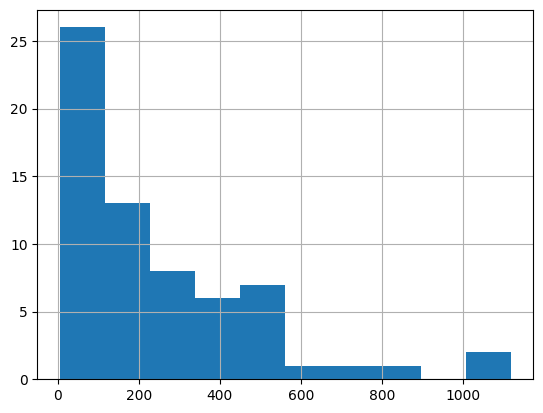

In [ ]:
test_data.groupby('user_id')['correct'].count().hist()

## PCA analysis

In [ ]:


# Create some example data

data = all_skill_embd.detach().numpy()  # 100 samples, 2 features

# Instantiate PCAwith the number of components you want
n_components = 3
pca = PCA(n_components=n_components)

# Fit the model and transform the data
data_pca = pca.fit_transform(data)




In [ ]:
df_data ={  'f' + str(i+1):data_pca[:,i] for i in range(n_components)}

In [ ]:
pca_df= pd.DataFrame(data=df_data)

In [ ]:
lo_count = df.learning_objective_name.nunique()
atom_count = df.atomIndex.nunique()

In [ ]:
df_processed,skill_graph = process_dataframe(df,df2,3)

In [ ]:
pca_df['feature_type'] = ['learning_objective' for i in range(lo_count)] +['question' for i in range(atom_count)]

In [ ]:
pca_df

,f1,f2,f3,feature_type
0,-1.819928,0.987114,-1.834169,learning_objective
1,-0.880454,-0.747022,-0.081503,learning_objective
2,-2.288293,1.107487,-1.690356,learning_objective
3,-0.690189,0.748192,-1.059427,learning_objective
4,-0.817519,0.579107,-0.805536,learning_objective
...,...,...,...,...
708,3.282906,-0.857249,0.673612,question
709,4.099023,-0.716889,1.097307,question
710,3.066736,-0.731894,0.814768,question
711,1.325256,-1.479282,1.084030,question


In [ ]:
lo_atom_map=lo_atom_map.sort_values(by='atomIndex')

In [ ]:
pca_df.loc[pca_df.feature_type == 'question','loIndex'	]= lo_atom_map['loIndex'].values

In [ ]:
pca_df['difficulty'] = 0
pca_df.loc[lo_count:,'difficulty' ] = df_processed[['atomIndex','difficulty']].drop_duplicates().sort_values('atomIndex')['difficulty'].values
pca_df.loc[:lo_count-1,'difficulty' ] =  df_processed.groupby('loIndex')['difficulty'].mean().values


In [ ]:
pca_df.feature_type.value_counts()

question              682
learning_objective     31
Name: feature_type, dtype: int64

In [ ]:


learning_objectives_trace = go.Scatter3d(
    x=pca_df[pca_df['feature_type'] == 'learning_objective']['f1'],
    y=pca_df[pca_df['feature_type'] == 'learning_objective']['f2'],
    z=pca_df[pca_df['feature_type'] == 'learning_objective']['f3'],
    mode='markers',
    marker=dict(size=4.5, color= 'green'),
    name='Learning Objectives'
)

questions_trace = go.Scatter3d(
    x=pca_df[pca_df['feature_type'] == 'question']['f1'],
    y=pca_df[pca_df['feature_type'] == 'question']['f2'],
    z=pca_df[pca_df['feature_type'] == 'question']['f3'],
    mode='markers',
    marker=dict(size=2.5, color=pca_df[pca_df['feature_type'] == 'question']['difficulty'], opacity=0.7,symbol='x',colorbar=dict(title='Difficulty')),
    name='Questions'
)

# Create the 3D scatter plot layout
layout = go.Layout(scene=dict(xaxis_title='f1', yaxis_title='f2', zaxis_title='f3'),
                   title='Question and Learning Objective Embeddings')

# Combine the traces and layout
fig = go.Figure(data=[learning_objectives_trace, questions_trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
lo_features =pca_df[pca_df.feature_type=='learning_objective']
question_features = pca_df[pca_df.feature_type=='question']

In [ ]:
lo_features

,f1,f2,f3,feature_type,loIndex,difficulty
0,-1.819928,0.987114,-1.834169,learning_objective,NaN,0.514890
1,-0.880454,-0.747022,-0.081503,learning_objective,NaN,0.446782
2,-2.288293,1.107487,-1.690356,learning_objective,NaN,0.488746
3,-0.690189,0.748192,-1.059427,learning_objective,NaN,0.514105
4,-0.817519,0.579107,-0.805536,learning_objective,NaN,0.366224
5,-2.022184,0.751261,-1.367315,learning_objective,NaN,0.523099
6,-0.410740,-1.557782,0.502442,learning_objective,NaN,0.511653
7,-0.139094,-1.598350,0.469065,learning_objective,NaN,0.509446
8,-1.314101,4.722596,3.364607,learning_objective,NaN,0.612136
9,-2.227572,1.148372,-1.542672,learning_objective,NaN,0.624831


In [ ]:


# Create a 3D scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=lo_features.f1, y=lo_features.f2, z=lo_features.f3, mode='markers', marker=dict(size=4.5, color='green'),name='learning_objective'))
fig.add_trace(go.Scatter3d(x=question_features.f1, y=question_features.f2, z=question_features.f3, mode='markers', marker=dict(size=2, color=question_features.loIndex, symbol='x'), name='question'))


# Set labels
fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

# Set title
fig.update_layout(title='Question and Learning Objective Embeddings')

# Show the plot in Google Colab
fig.show()


In [ ]:
pca_df

,f1,f2,f3,feature_type,loIndex,difficulty
0,-1.819928,0.987114,-1.834169,learning_objective,NaN,0.514890
1,-0.880454,-0.747022,-0.081503,learning_objective,NaN,0.446782
2,-2.288293,1.107487,-1.690356,learning_objective,NaN,0.488746
3,-0.690189,0.748192,-1.059427,learning_objective,NaN,0.514105
4,-0.817519,0.579107,-0.805536,learning_objective,NaN,0.366224
...,...,...,...,...,...,...
708,3.282906,-0.857249,0.673612,question,11.0,0.500000
709,4.099023,-0.716889,1.097307,question,11.0,1.000000
710,3.066736,-0.731894,0.814768,question,11.0,0.500000
711,1.325256,-1.479282,1.084030,question,11.0,1.000000


In [ ]:


# Create some example data

data = all_skill_embd.detach().numpy()  # 100 samples, 2 features

# Instantiate PCAwith the number of components you want
n_components = 2
pca = PCA(n_components=n_components)

# Fit the model and transform the data
data_pca = pca.fit_transform(data)




In [ ]:
df_data ={  'f' + str(i+1):data_pca[:,i] for i in range(n_components)}

In [ ]:
pca_df= pd.DataFrame(data=df_data)

In [ ]:
lo_count = df.learning_objective_name.nunique()
atom_count = df.atomIndex.nunique()

In [ ]:
df_processed,skill_graph = process_dataframe(df,df2,3)

In [ ]:
pca_df['feature_type'] = ['learning_objective' for i in range(lo_count)] +['question' for i in range(atom_count)]

In [ ]:
lo_atom_map=lo_atom_map.sort_values(by='atomIndex')

In [ ]:
pca_df.loc[pca_df.feature_type == 'question','loIndex'	]= lo_atom_map['loIndex'].values

In [ ]:
pca_df.loc[pca_df.feature_type == 'learning_objective','loIndex'	] = lo_atom_map.loIndex.sort_values().unique().tolist()

In [ ]:
pca_df['difficulty'] = 0
pca_df.loc[lo_count:,'difficulty' ] = df_processed[['atomIndex','difficulty']].drop_duplicates().sort_values('atomIndex')['difficulty'].values
pca_df.loc[:lo_count-1,'difficulty' ] =  df_processed.groupby('loIndex')['difficulty'].mean().values


In [ ]:
lo_pca= pca_df[pca_df.feature_type=='learning_objective']

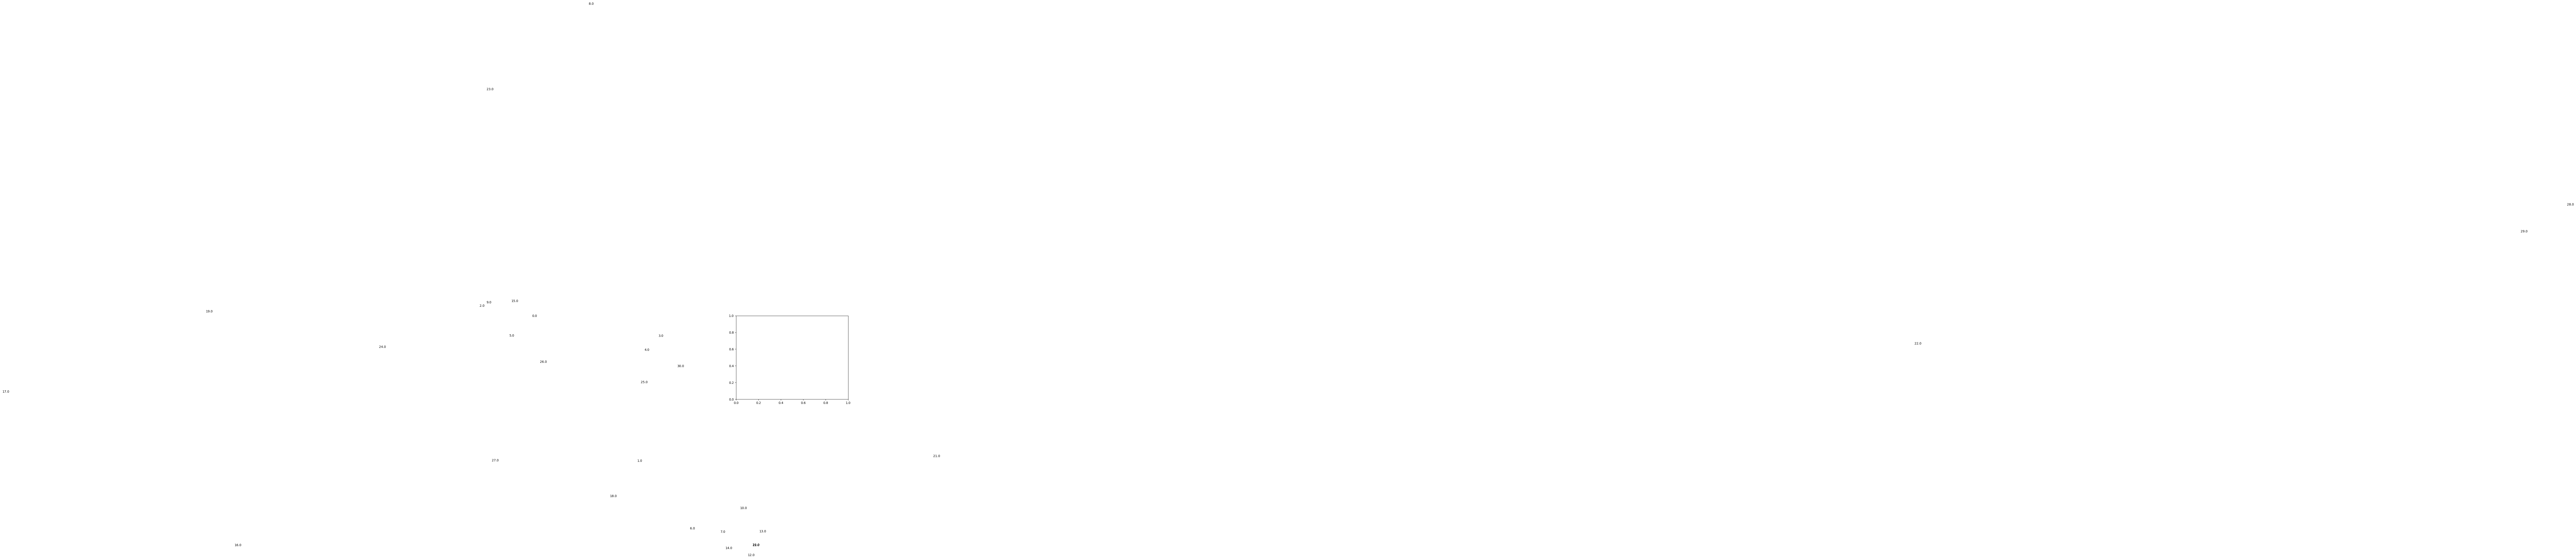

In [ ]:
plt.title?

Text(0.5, 1.0, 'Embeddings - PCA Analysis')

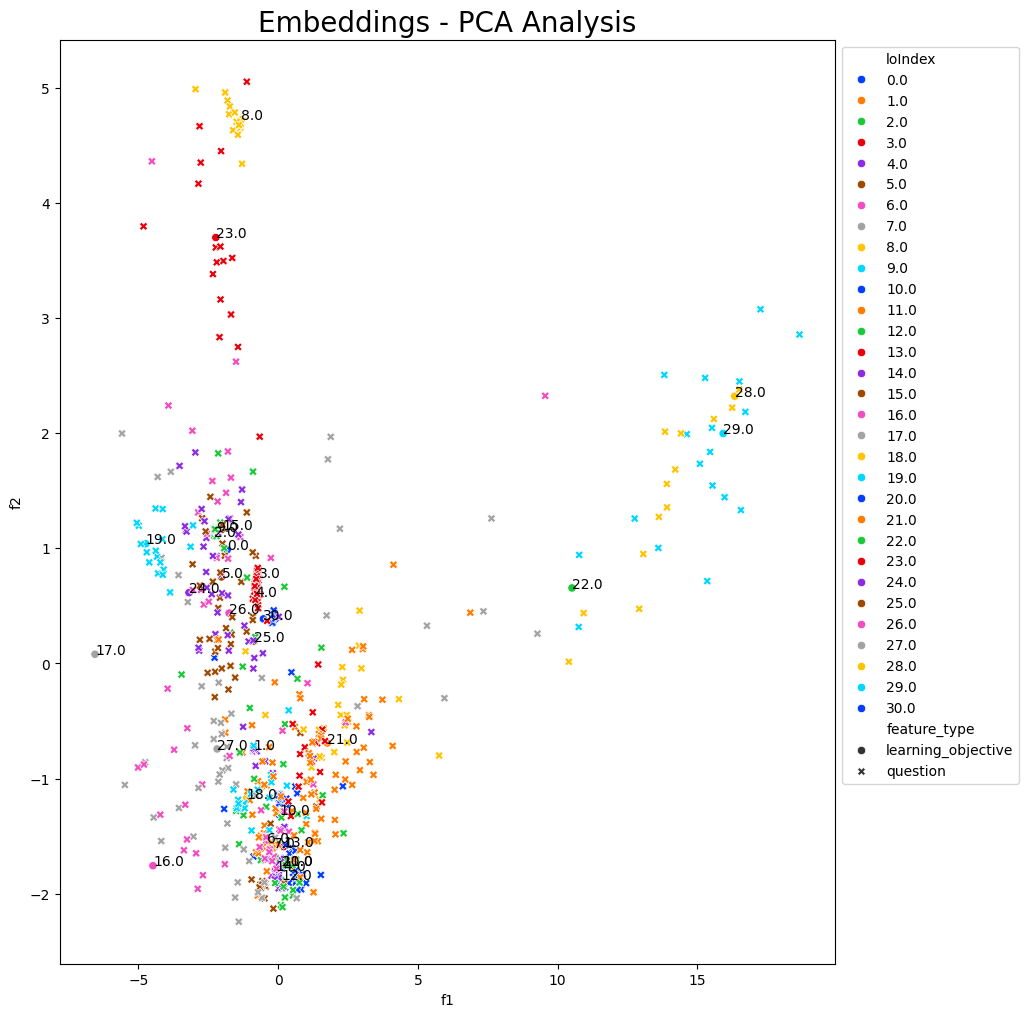

In [ ]:
plt.figure(figsize=(10,12))
sns.scatterplot(data=pca_df[(pca_df.f1>-10) & (pca_df.f2<6)],x='f1',y='f2',hue='loIndex',palette='bright',style='feature_type')
for row_num,row in lo_pca.iterrows():
  plt.text(row['f1'],row['f2'],row['loIndex'])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Embeddings - PCA Analysis',fontdict={'size':20})

<ipython-input-93-a519d4d391a2>:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<Axes: xlabel='f1', ylabel='f2'>

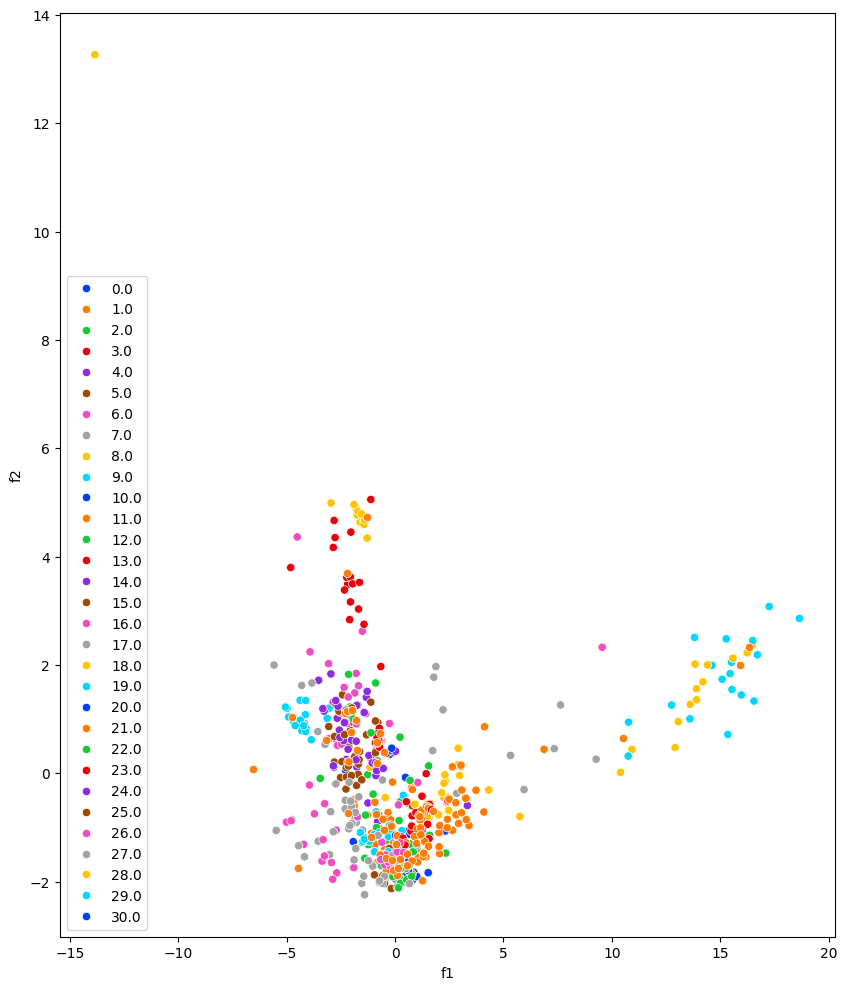

In [ ]:
plt.figure(figsize=(10,12))
sns.scatterplot(data=pca_df[pca_df.feature_type=='question'],x='f1',y='f2',hue='loIndex',palette='bright')
sns.scatterplot(data=pca_df[pca_df.feature_type=='learning_objective'],x='f1',y='f2',palette='bright')

<Axes: xlabel='f1', ylabel='f2'>

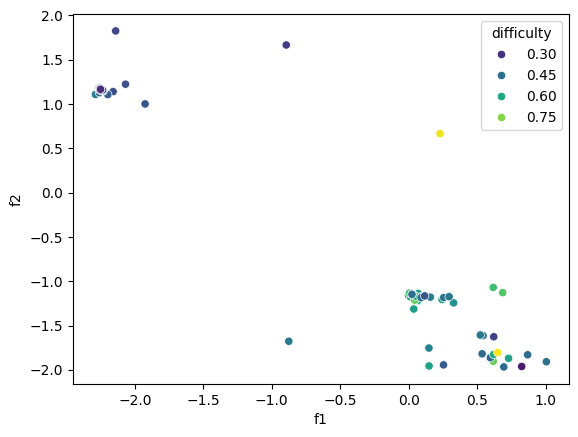

In [ ]:
sns.scatterplot(data=pca_df[pca_df.loIndex.isin([20,10,2])],x='f1',y='f2',hue='difficulty',palette='viridis')


In [ ]:
pca_df.corr()

<ipython-input-95-03175e6b451a>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,f1,f2,loIndex,difficulty
f1,1.000000e+00,4.469937e-09,0.225068,0.335890
f2,4.469937e-09,1.000000e+00,0.247550,0.240337
loIndex,2.250682e-01,2.475502e-01,1.000000,0.345054
difficulty,3.358899e-01,2.403370e-01,0.345054,1.000000
